# Flopy example
using multiple modflow6 packages, using shapefiles

In [1]:
import flopy
import numpy as np

flopy is installed in C:\thomas\Anaconda3\lib\site-packages\flopy


In [2]:
# build simple flopy georeferenced model
modelname = 'example'

# create simulation with modflow6
sim = flopy.mf6.MFSimulation(sim_name='example', version='mf6', exe_name='mf6', sim_ws='output/flopy example')
# create model in simulation
mf = flopy.mf6.ModflowGwf(sim, modelname=modelname)
# create the flopy iterative model solver (ims) package object
ims = flopy.mf6.modflow.mfims.ModflowIms(sim)
# create discretization object, time, 1 steady state period of 1 second, transient period of 1 day (or 86400s)
tdis = flopy.mf6.ModflowTdis(sim, time_units='days', nper=2, perioddata=[(1.0,10,1.0), (2000.,10,1.0)]) # period len, period steps, period multiplier

In [3]:
# import model limit
import shapefile as sf
ml = sf.Reader('data/flopy example/masker.shp')
# create numpy array based on the model limit
la = np.array(ml.shapeRecords()[0].shape.points)

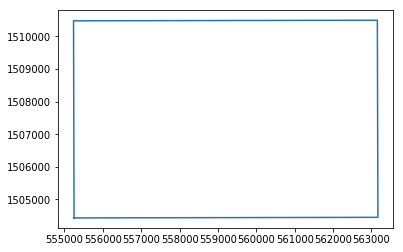

In [4]:
# simple plot of model limit
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(la[:,0], la[:,1])

In [5]:
# model limit with osm background
import mplleaflet

crs = {'init': 'epsg:32630'}
mplleaflet.display(fig, crs=crs)

C:\thomas\Anaconda3\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\thomas\Anaconda3\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\thomas\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [6]:
# values for spatial discretization
bbox = ml.bbox # coordinates of the model limit
Lx = bbox[2] - bbox[0] # xmax - xmin
Ly = bbox[3] - bbox[1] # ymax - ymin
nlay = 3 # number of layers
mtop = 0 # top elevation
botm = [-10, -20, -30] # bottom elevation of each layer
delr = delc = 100 # x, y width of cell
ncol, nrow = round(Lx/delr), round(Ly/delc) # calculate number of rows, and columns based on model limit en given resolution

# create discretization object, spatial
dis = flopy.mf6.ModflowGwfdis(mf, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr, delc=delc, top=mtop, botm=botm, length_units='METERS')
# set spatial reference for dis package, use epsg 32630 UTM Zone 30N
from flopy.utils.reference import SpatialReference
mf.dis.sr = SpatialReference(delr=np.full(ncol, delr), delc=np.full(nrow, delc), xul=bbox[0], yul=bbox[3], epsg=32630)
# set coordinates for modelgrid based on model limit extends
mf.modelgrid.set_coord_info(xoff=bbox[0], yoff=bbox[3]-np.full(nrow, delc).sum(), angrot=0, epsg=32717)

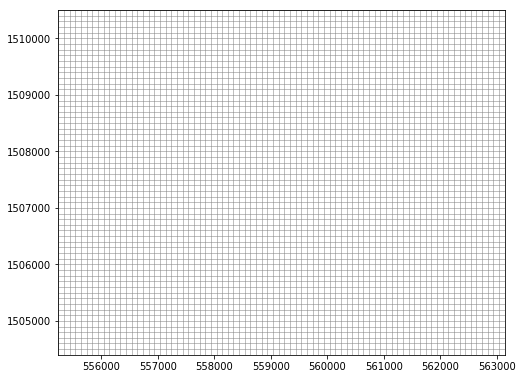

In [7]:
# simple plot created modelgrid
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.PlotMapView(model=mf)
linecollection = modelmap.plot_grid(linewidth=0.5, color='grey')

In [8]:
# plot created modelgrid with osm
fig = plt.figure()
modelmap = flopy.plot.PlotMapView(model=mf)
linecollection = modelmap.plot_grid(linewidth=0.5, color='grey')
mplleaflet.display(fig, crs=crs)

C:\thomas\Anaconda3\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\thomas\Anaconda3\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\thomas\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [9]:
# load dem into array, to use later
from osgeo import gdal
ds = gdal.Open('data/flopy example/dem.tif') # exported dem clipped by model extend and set resolution equal to model resolution
dem = ds.GetRasterBand(1).ReadAsArray()
print('dem array: ', dem.shape) # check if they have same dimensions
print('modflow grid: ', (nrow, ncol))

dem array:  (61, 79)
modflow grid:  (61, 79)


In [10]:
dem

array([[341., 345., 346., ..., 342., 345., 346.],
       [344., 344., 345., ..., 348., 346., 346.],
       [343., 343., 341., ..., 346., 347., 345.],
       ...,
       [333., 335., 336., ..., 337., 336., 338.],
       [336., 335., 335., ..., 337., 338., 339.],
       [335., 336., 336., ..., 338., 338., 337.]])

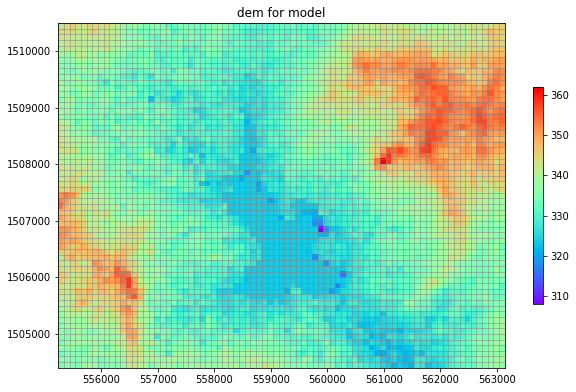

In [11]:
# plot created modelgrid
fig = plt.figure(figsize=(10,8))
modelmap = flopy.plot.PlotMapView(model=mf)
linecollection = modelmap.plot_grid(linewidth=0.5, color='grey')
quadmesh = modelmap.plot_array(dem, cmap='rainbow')
plt.colorbar(quadmesh, shrink=0.5)
plt.title('dem for model');

In [12]:
# assign the dem layer, as surface elevations
mf.dis.top = dem

In [13]:
# assign three layer based on dem, made some simple assumptions
inf_bottom = -120 # bottom level 120 meters below datum
med_bottom = inf_bottom + (0.5 * (dem - inf_bottom)) # just assumption
sup_bottom = inf_bottom + (0.75 * (dem - inf_bottom)) # another assumption
# create array with zeroes
zbot = np.zeros((nlay, nrow, ncol))
zbot[0::] = sup_bottom
zbot[1::] = med_bottom
zbot[2::] = inf_bottom
# assign layer bottom elevations
mf.dis.botm = zbot

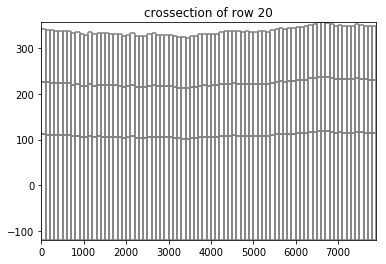

In [14]:
# plot cros section of row 20
fig = plt.figure()
modelxsect = flopy.plot.PlotCrossSection(model=mf, line={'Row':20})
linecollection = modelxsect.plot_grid()
plt.title('crossection of row 20');

In [15]:
# set the hydraulic conductivity, some assumptions again
k = np.zeros((nlay, nrow, ncol))
k[0::] = 1E-5 # first layer of lime
k[0::] = 5E-4 # second layer of sand
k[2::] = 2E-4 # third layer of sandy gravel

# define hydraulic properties
npf = flopy.mf6.ModflowGwfnpf(mf, icelltype=1, save_flows=True, k=k) # hydraulic conductivity for each layer

# define dynamic hydraulic parameters, the first two layers are convertible and the second layer confined
sto = flopy.mf6.ModflowGwfsto(mf, save_flows=True, iconvert=[1,1,0], ss=1e-5, sy=0.15, 
                              steady_state={0:True}, transient={1:True}) # ss, specific storage, sy, specific yield

# set initials heads equal to mean surface level
ic = flopy.mf6.ModflowGwfic(mf, strt=dem.mean())

In [16]:
# recharge and evt boundary condition
# evapotranspiration rate
evtr = 1.2 / 365. / 86400. # 1200 mm/yr in m/s
evt = flopy.mf6.ModflowGwfevta(mf, rate=evtr, surface=dem)

# recharge rate
rechr = 0.2 / 365. / 86400 # 200 mm/yr in m/s
rch = flopy.mf6.ModflowGwfrcha(mf, recharge=rechr)

In [17]:
# use gridgen to get lake mask
from flopy.utils.gridgen import Gridgen
g = Gridgen(mf.dis, model_ws='data/flopy example', exe_name='C:/thomas/modflow/gridgen.1.0.02/bin/gridgen.exe')
g.build(verbose=False)
lake = g.intersect('lake', 'polygon', 0)

C:\thomas\Anaconda3\lib\site-packages\flopy\utils\gridgen.py:1552: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  usecols=tuple(range(ncol)))


In [18]:
lake_unique = np.unique(lake.nodenumber) # select all unique lake cell-ids
lake_0 = np.zeros([nrow, ncol])
for i in np.arange(lake_unique.shape[0]):
    x, y = g.get_center(lake_unique[i]) # get the cell centroid x and y
    i, j = mf.dis.sr.get_ij(x, y) # get the cell row and column
    lake_0[i,j] = 324 # set constant head in lake to 324 (from dem)

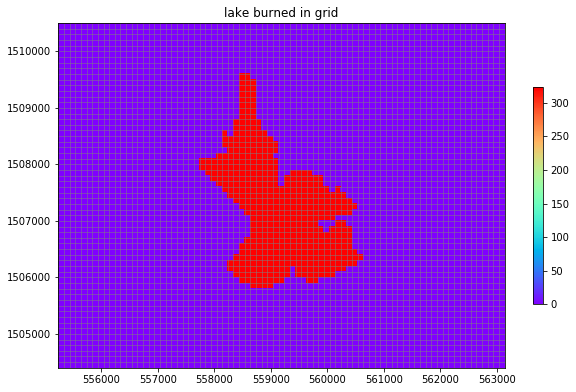

In [19]:
# show resulting grid with lake cells, elevation lake is 324
fig = plt.figure(figsize=(10,8))
modelmap = flopy.plot.PlotMapView(model=mf)
linecollection = modelmap.plot_grid(linewidth=0.5, color='grey')
quadmesh = modelmap.plot_array(lake_0, cmap='rainbow')
plt.colorbar(quadmesh, shrink=0.5)
plt.title('lake burned in grid');